In [4]:
import numpy
import warnings
warnings.filterwarnings('ignore')  # Disable all warnings
warnings.filterwarnings("ignore", message="Exception ignored on calling ctypes callback function")
import os
import random
import time

import numpy as np
import pandas as pd
import torch
import random
from pathlib import Path
from scipy.sparse import csr_matrix, save_npz, load_npz
from scipy.stats import pearsonr
from typing import Dict, Tuple
from tqdm import tqdm
from collections import defaultdict
import polars as pl
import json
from scipy import stats
import multiprocessing

import MultiChat as MC

# Processing

In [ ]:
base_path = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/'
db = pd.read_csv(os.path.join(base_path, "inputs/LRpairDB_merge.csv"), header=0, sep=",")
cell_rep = pd.read_csv(os.path.join(base_path, "HGEmb/Cell_rep.csv"), header=0, index_col=0, sep=",")
expmatrix = pd.read_csv(os.path.join(base_path, "inputs/RNAmatrix.csv"), header=0, index_col=0, sep=",")
non_zero_counts = (expmatrix > 0).sum(axis=1)
expmatrix_filt1 = expmatrix[non_zero_counts >= 5]
split_ligand_symbols = db['Ligand_Symbol'].str.split('_') 
mask_ligand = split_ligand_symbols.apply(lambda symbols: all(symbol in expmatrix_filt1.index for symbol in symbols)) 
db_filt1 = db[mask_ligand] 
split_receptor_symbols = db_filt1['Receptor_Symbol'].str.split('_') 
mask_receptor = split_receptor_symbols.apply(lambda symbols: all(symbol in expmatrix_filt1.index for symbol in symbols)) 
db_filt1 = db_filt1[mask_receptor] 
lig_exp, rec_exp = MC.Processing.Preprocess_CCC_model(base_path, db_filt1, cell_rep, expmatrix_filt1)

# run InterCCC

In [ ]:
'''get postive pairs'''
cell_clus = pd.read_csv(base_path+'inputs/celltype_info.csv', header=0, index_col=0, sep="\t")
cell_clus.rename(columns={'celltype': 'cell_type'}, inplace=True)
cell_loc = pd.read_csv(base_path+'inputs/Coord.csv', header=0, index_col=0)
parser                  =  MC.utilities.parameter_setting()
args, unknown           = parser.parse_known_args()
args.inputPath          = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/'
args.outPath            = args.inputPath + 'CCC/'
MC.utilities.get_cell_positive_pairs(cell_clus, cell_loc, args)

In [ ]:
parser  =  MC.utilities.parameter_setting() 
args, unknown = parser.parse_known_args()

args.gpu_id = 0
if args.use_cuda and torch.cuda.is_available():
    device = torch.device(f'cuda:{args.gpu_id}')
    torch.cuda.set_device(args.gpu_id)
else:
    device = torch.device('cpu')

## random seed 
numpy.random.seed( args.seed )
random.seed( args.seed )
torch.manual_seed( args.seed )
torch.cuda.manual_seed( args.seed )

start = time.time()
args.inputPath          = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/'
args.use_cuda           = args.use_cuda and torch.cuda.is_available()

args.outPath            = args.inputPath + 'CCC/'	
args.spatialLocation    = args.inputPath + 'inputs/' + 'Coord.csv'
args.annoFile           = args.inputPath + 'inputs/' + 'celltype_info.csv'
args.pos_pair           = args.outPath + args.pos_pair

args.Ligands_exp        = args.outPath + args.Ligands_exp
args.Receptors_exp      = args.outPath + args.Receptors_exp

args.patience           = 15
args.lr_cci             = 0.001
args.attn_drop          = 0
args.tau                = 0.05

args.selected_cell_type = None
args.InterCCC_Name      = 'LRI_module_strength.txt'

MC.model_training.Train_CCC_model(args)
	
duration = time.time() - start
print('Finish training, total time is: ' + str(duration) + 's' )

spot location for adjacency
loading cell type annotations
Calculating pairwise distances between spots
spot-ligand data
spot-receptor data
Size of CCC pairs: 1986
Start model training
Using GPU: 0
0 cost: tensor(428.9597)
10 cost: tensor(12.4756) tensor(0.0211, device='cuda:0', grad_fn=<DivBackward0>)
20 cost: tensor(5.5869) tensor(0.0697, device='cuda:0', grad_fn=<DivBackward0>)
30 cost: tensor(3.2120) tensor(0.0437, device='cuda:0', grad_fn=<DivBackward0>)
40 cost: tensor(1.8616) tensor(0.0431, device='cuda:0', grad_fn=<DivBackward0>)
50 cost: tensor(1.4508) tensor(0.0197, device='cuda:0', grad_fn=<DivBackward0>)
60 cost: tensor(1.1564) tensor(0.0223, device='cuda:0', grad_fn=<DivBackward0>)
70 cost: tensor(0.9581) tensor(0.0159, device='cuda:0', grad_fn=<DivBackward0>)
80 cost: tensor(0.8263) tensor(0.0143, device='cuda:0', grad_fn=<DivBackward0>)
90 cost: tensor(0.7177) tensor(0.0136, device='cuda:0', grad_fn=<DivBackward0>)
100 cost: tensor(0.6303) tensor(0.0125, device='cuda:0', 

## Generate Background InterCCC data

In [ ]:
'''Step1:get background postive pairs'''
pos_pair = pd.read_csv(base_path + 'CCC/Spot_positive_pairs.txt', header=None, index_col=None, sep="\t")
pos_pair_perturb = pos_pair.apply(MC.utilities.perturb_pos_pair_row, axis=1)
lig_exp = pd.read_csv(base_path + 'CCC/ligands_expression.txt', header=0, index_col=0, sep="\t")
rec_exp = pd.read_csv(base_path + 'CCC/receptors_expression.txt', header=0, index_col=0, sep="\t")
lig_exp_shuffled = lig_exp.apply(np.random.permutation)
rec_exp_shuffled = rec_exp.apply(np.random.permutation)
lig_exp_shuffled.to_csv(base_path + 'Bg_CCC/ligands_expression_shuffled.txt', sep="\t")
rec_exp_shuffled.to_csv(base_path + 'Bg_CCC/receptors_expression_shuffled.txt', sep="\t")
pos_pair_perturb.to_csv(base_path + 'Bg_CCC/Spot_positive_pairs_shuffled.txt', sep="\t", header=False, index=False)

In [ ]:
'''Step2-1:Run MultiChat_Inter to generate 10 sets of background data in parallel'''
def run_training(run_idx):  
    parser = MC.utilities.parameter_setting()
    args, unknown = parser.parse_known_args()
    args.gpu_id = 0
    
    base_seed = 42  
    args.seed = base_seed + run_idx
    
    if args.use_cuda and torch.cuda.is_available():
        device = torch.device(f'cuda:{args.gpu_id}')
        torch.cuda.set_device(device)  
    else:
        device = torch.device('cpu')
    
    np.random.seed(args.seed)
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(args.seed)
    
    start = time.time()
    start = time.time()
    args.inputPath          = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/'
    args.use_cuda           = args.use_cuda and torch.cuda.is_available()

    args.outPath            = args.inputPath + 'Bg_CCC/'	
    args.spatialLocation    = args.inputPath + 'inputs/' + 'Coord.csv'
    args.annoFile           = args.inputPath + 'inputs/' + 'celltype_info.csv'
    args.pos_pair           = args.outPath + 'Spot_positive_pairs_shuffled.txt'
    args.Ligands_exp        = args.outPath + 'ligands_expression_shuffled.txt'
    args.Receptors_exp      = args.outPath + 'receptors_expression_shuffled.txt'
    
    args.patience = 15
    args.lr_cci = 0.001
    args.attn_drop = 0
    args.tau = 0.05
    
    args.lrp_strength_file = args.outPath + f'LRI_module_strength_run_{run_idx}.txt'
    
    # Run training
    MC.model_training.Train_CCC_model_parallel(args)
    
    duration = time.time() - start
    print(f'Finish training run {run_idx}, total time: {duration}s')

In [ ]:
'''Step2-2:Run MultiChat_Inter to generate 10 sets of background data in parallel'''
if __name__ == '__main__':
    run_indices = list(range(1, 11))  # [1, 2, 3, ..., 10]
    
    with multiprocessing.Pool(processes=5) as pool:
        pool.map(run_training, run_indices)

# Identify Significant L->R pair

## Identify singl-cell level significant L->R pair

In [ ]:
base_path = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/'
background_inter_df = MC.Intra_strength.load_background_inter(base_path+'Bg_CCC/', file_pattern="LRI_module_strength_run_*.txt")
background_inter_df.to_csv(base_path + 'Bg_CCC/LRI_module_strength_run_concat.txt', sep="\t", index=True)
sample_inter_df = pd.read_csv(base_path+'CCC/LRI_module_strength.txt', sep='\t', index_col=0)  
lr_lst = sample_inter_df.columns.tolist() 
sub_background_inter_df = background_inter_df.loc[:, lr_lst] 

In [ ]:
sig_LR_pair = MC.Intra_strength.Identify_significant_lr_pairs(
    background_inter_df=sub_background_inter_df,
    sample_inter_df=sample_inter_df,
    output_path=base_path+'CCC/Significant_LRs.csv',
    z_critical=None,
    alpha=0.05
)
sig_LR_pair.head()

Processing samples: 2487it [00:02, 978.31it/s] 


Significant_L->R pairs saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC_GroundTruth/CCC/Significant_LRs.csv


,Sample_Name,LR_Symbol,Inter_Score,Z_Score
0,CCCTAGTTCGTTGTTT-1,Gm39027->Olfr646,0.012919,7.115690
1,CCCTAGTTCGTTGTTT-1,Slc14a2->Tdgf1,0.003989,4.185134
2,CCCTAGTTCGTTGTTT-1,Gm11670->Gm43791,0.004581,3.294356
3,CCCTAGTTCGTTGTTT-1,C130060C02Rik->Gm4279,0.006734,3.076004
4,CCCTAGTTCGTTGTTT-1,Gdf11->Tgfbr1_Acvr2a,0.011488,2.917302


## Identify cell-type level Significant L->R pair

In [ ]:
background_inter_df = MC.Intra_strength.load_background_inter(base_path+'Bg_CCC/', file_pattern="LRI_module_strength_run_*.txt") 
sample_inter_df = pd.read_csv(base_path+'CCC/LRI_module_strength.txt', sep='\t', index_col=0)   
cell_clus = pd.read_csv(base_path+'/inputs/celltype_info.csv', header=0, index_col=0, sep="\t") 
sig_LR_pair = pd.read_csv(base_path+'CCC/Significant_LRs.csv', header=0, sep=",")
sig_LR_pair_celltype = MC.Intra_strength.Identify_significant_lr_pairs_celltype(sig_LR_pair, cell_clus, agg_method='mean')
merged = sample_inter_df.join(cell_clus)   
sample_inter_ct_df = merged.groupby('celltype').mean() 
sample_inter_ct_df.index.name = None 
vola_LR_pair_celltype, vola_LR_pair_celltype_vscore,vola_LR_pair_celltype_bin,_ = MC.Intra_strength.Identify_volatile_lr_pairs_celltype(sample_inter_ct_df, threshold=2.5, method='mad')
outs_path = base_path+'CCC/Significant_LRs_ct_concat.csv' 
sig_LR_pair_celltype_concat = MC.Intra_strength.Identify_concat_lr_pairs_celltype(sig_LR_pair_celltype,vola_LR_pair_celltype,outs_path)

sig_LR_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC_GroundTruth/CCC/Significant_LRs_ct_concat.csv


# run IntraCCC

## Load data

In [ ]:
rna_mat = pd.read_csv(base_path + 'CCC/expression_smooth.txt', header=0, index_col=0, sep="\t")
atac_mat = pl.read_csv(base_path + 'inputs/ATACmatrix.csv')
atac_mat = atac_mat.to_pandas().set_index(atac_mat.columns[0])
tg_re_df = pd.read_csv(base_path + 'inputs/TG_RE_score_df_up2kb_cutoff05_overlap.csv', sep="\t")
gene_rep = pd.read_csv(base_path + 'HGEmb/Gene_rep.csv', index_col=0)
cell_rep = pd.read_csv(base_path + 'HGEmb/Cell_rep.csv', index_col=0)
sample_order = rna_mat.columns.tolist()
cell_rep_aligned = cell_rep.loc[sample_order]
tf_rep = pd.read_csv(base_path + 'HGEmb/TF_rep.csv', index_col=0)
lst = tf_rep.index.tolist()
new_lst = [item.replace('M_', '', 1) for item in lst]
tf_rep.index = new_lst
peak_rep = pd.read_csv(base_path + 'HGEmb/Peak_rep.csv', index_col=0)
tf_re_ba = pd.read_csv(base_path + 'HGEmb/TF_RE_ba.csv', index_col=0)
l_r_df = pd.read_csv(base_path + 'inputs/LRpairDB_merge_filt1.csv') 
r_tf_cellcall = pd.read_csv(base_path + 'inputs/new_ligand_receptor_TFs_homology.txt', sep='\t')

## Build L-R-TF-TG database

In [ ]:
tf_tg_common_peaks = MC.Intra_strength.build_tf_tg_mapping(tg_re_df, tf_re_ba)
l_r_tf_df = MC.Intra_strength.generate_l_r_tf_pairs(l_r_df, r_tf_cellcall)
l_r_tf_df.to_csv(base_path + 'inputs/Ligand_Receptor_TF_pairs.csv', sep="\t", index=False)
L_R_TF_TG_df = MC.Intra_strength.generate_l_r_tf_tg_pairs(l_r_tf_df, tf_tg_common_peaks)
L_R_TF_TG_df.to_csv(base_path + 'inputs/Ligand_Receptor_TF_TG_pairs.csv', sep="\t", index=False)

Processing L-R-TF-TG pairs: 9875it [00:18, 523.25it/s]


In [ ]:
unique_counts = L_R_TF_TG_df.nunique()
unique_counts

Ligand_Symbol      133
Receptor_Symbol    130
TF_Symbol          107
TG_Symbol           62
dtype: int64

## Get TF-TG Strength

In [11]:
rna_mat_minmax = (rna_mat - rna_mat.min()) / (rna_mat.max() - rna_mat.min()) # column-wise normalization
atac_mat_minmax = atac_mat.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1) # row-wise normalization

In [ ]:
path_outs = base_path + 'CCC/TF_TG/'
tf_tg_scores = MC.Intra_strength.calculate_all_tf_tg_scores(
    rna_mat=rna_mat_minmax,
    atac_mat=atac_mat_minmax,
    tg_re_df=tg_re_df,
    tf_rep=tf_rep,
    peak_rep=peak_rep,
    tf_re_ba=tf_re_ba,
    gene_rep=gene_rep,
    path=path_outs
)

tf_tg_scores.head()

Processing cells: 100%|██████████| 2487/2487 [52:37<00:00,  1.27s/it]  


,Esr1->Acsl3,Esr1->Serpine2,Esr1->Gpr37l1,Esr1->Glul,Esr1->Atp1b1,Esr1->Atp1a2,Esr1->Kcnj10,Esr1->Gja1,Esr1->Serinc1,Esr1->Timp3,...,Elf5->Luzp2,Elf5->Mfge8,Elf5->Dkk3,Elf5->Mical2,Elf5->Spon1,Elf5->Hs3st4,Elf5->Htra1,Elf5->Hepacam,Elf5->Tmem30a,Elf5->Cck
CCCTAGTTCGTTGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCTGTTCTCGTTGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CGCTATCTCGTTGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACCAAACAGCGTGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATTGTCTTCCATGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
tf_tg_scores_df = tf_tg_scores.loc[:, (tf_tg_scores != 0).any()]
tf_tg_scores_df.head()

,Esr1->Acsl3,Esr1->Gpr37l1,Esr1->Glul,Esr1->Atp1b1,Esr1->Atp1a2,Esr1->Kcnj10,Esr1->Serinc1,Esr1->Timp3,Esr1->Atp2b1,Esr1->Syt1,...,Elf5->Slc6a1,Elf5->Chd4,Elf5->Kcna1,Elf5->Atp1a3,Elf5->Slc7a10,Elf5->Luzp2,Elf5->Mfge8,Elf5->Dkk3,Elf5->Mical2,Elf5->Tmem30a
CCCTAGTTCGTTGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCTGTTCTCGTTGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CGCTATCTCGTTGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACCAAACAGCGTGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATTGTCTTCCATGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Get R-TF PCC

In [11]:
l_r_tf_df = pd.read_csv(base_path + 'inputs/Ligand_Receptor_TF_pairs.csv', sep="\t")
l_r_tf_df.head()

,Ligand_Symbol,Receptor_Symbol,TF_Symbol
0,Tgfb1,Tgfbr1_Tgfbr2,Atf4
1,Tgfb1,Tgfbr1_Tgfbr2,Atf2
2,Tgfb1,Tgfbr1_Tgfbr2,Daxx
3,Tgfb1,Tgfbr1_Tgfbr2,Ddit3
4,Tgfb1,Tgfbr1_Tgfbr2,E2f1


In [12]:
rec_tf_df = l_r_tf_df[['Receptor_Symbol', 'TF_Symbol']].drop_duplicates()
rec_tf_df = rec_tf_df.reset_index(drop=True)
rec_tf_df.head()

,Receptor_Symbol,TF_Symbol
0,Tgfbr1_Tgfbr2,Atf4
1,Tgfbr1_Tgfbr2,Atf2
2,Tgfbr1_Tgfbr2,Daxx
3,Tgfbr1_Tgfbr2,Ddit3
4,Tgfbr1_Tgfbr2,E2f1


In [ ]:
rec_tf_pcc = rec_tf_df.copy()
rec_tf_pcc['scores'] = rec_tf_pcc.apply(
    lambda row: MC.Intra_strength.calculate_pcc_rec_tf(gene_rep, tf_rep, row['Receptor_Symbol'], row['TF_Symbol']), axis=1
)
rec_tf_pcc = rec_tf_pcc.fillna(0)
rec_tf_pcc.to_csv(base_path + 'CCC/Receptor_TF_PCC.csv', index=False)
rec_tf_pcc.head()

,Receptor_Symbol,TF_Symbol,scores
0,Tgfbr1_Tgfbr2,Atf4,0.781463
1,Tgfbr1_Tgfbr2,Atf2,0.851703
2,Tgfbr1_Tgfbr2,Daxx,0.000000
3,Tgfbr1_Tgfbr2,Ddit3,0.721100
4,Tgfbr1_Tgfbr2,E2f1,0.336303


## Get R-TF-TG Strength

In [ ]:
tf_tg_scores_df = pd.read_csv(base_path + 'CCC/TF_TG/all_samples_tf_tg_scores.csv', sep=',', index_col=0)
rec_tf_pcc = pd.read_csv(base_path + 'CCC/Receptor_TF_PCC.csv', sep=',')

In [20]:
tf_tg_scores_df = tf_tg_scores_df.loc[:, (tf_tg_scores_df != 0).any()] 
tf_tg_scores_df.head()

,Esr1->Acsl3,Esr1->Gpr37l1,Esr1->Glul,Esr1->Atp1b1,Esr1->Atp1a2,Esr1->Kcnj10,Esr1->Serinc1,Esr1->Timp3,Esr1->Atp2b1,Esr1->Syt1,...,Elf5->Slc6a1,Elf5->Chd4,Elf5->Kcna1,Elf5->Atp1a3,Elf5->Slc7a10,Elf5->Luzp2,Elf5->Mfge8,Elf5->Dkk3,Elf5->Mical2,Elf5->Tmem30a
CCCTAGTTCGTTGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCTGTTCTCGTTGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CGCTATCTCGTTGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ACCAAACAGCGTGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ATTGTCTTCCATGTTT-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
cell_results_reg, combined_results_reg = MC.Intra_strength.calculate_r_tf_tg_reg_with_rexp(
    cell_rep=cell_rep_aligned,
    tf_tg_score_df=tf_tg_scores_df,
    rec_tf_pcc=rec_tf_pcc,
    rna_mat=rna_mat_minmax,
    output_dir=base_path+"CCC/R_TF_TG_Reg"
)

Processing cells: 100%|██████████| 2487/2487 [05:43<00:00,  7.25it/s]


In [ ]:
with open(base_path+'CCC/R_TF_TG_Reg/global_row_names.json', 'r') as f:
    global_row_names = json.load(f)
with open(base_path+'CCC/R_TF_TG_Reg/global_col_names.json', 'r') as f:
    global_col_names = json.load(f)

In [ ]:
cell_results_cor, combined_cor = MC.Intra_strength.calculate_r_tf_tg_cor(
    gene_rep=gene_rep,
    tf_rep=tf_rep,
    cell_rep=cell_rep_aligned,
    receptors=global_row_names,
    tf_tg_pairs=global_col_names,
    reg_dir = base_path+"CCC/R_TF_TG_Reg",
    output_dir=base_path+"CCC/R_TF_TG_Cor"
)

Precomputing PCC matrices...


Processing cells: 100%|██████████| 2487/2487 [04:50<00:00,  8.55it/s]


In [ ]:
cor_dir = base_path+"CCC/R_TF_TG_Cor"
reg_dir = base_path+"CCC/R_TF_TG_Reg"

cell_results_tol, combined_tol = MC.Intra_strength.calculate_r_tf_tg_strength(
    cell_rep =cell_rep_aligned,
    cor_dir=cor_dir,
    reg_dir=reg_dir,
    output_dir=base_path+"CCC/R_TF_TG"
)

Calculating total scores: 100%|██████████| 2487/2487 [04:08<00:00,  9.99it/s]


## Get L-R-TF-TG Strength

In [ ]:
# Default --------ligand-wise'''
MC.Intra_strength.calculate_l_r_tf_tg_strength(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"CCC/LRI_module_strength.txt",
    output_dir=base_path+"CCC/L_R_TF_TG/ligand_cascade_results"
)

Loading data...
Data loaded successfully
Identifying zero L-R pairs...
Found 35 zero L-R pairs to skip


Processing ligands: 100%|██████████| 133/133 [18:33<00:00,  8.37s/it] 

Processing completed. Results saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCCur/L_R_TF_TG/ligand_cascade_results


In [ ]:
# Default ------------TG-wise
MC.Intra_strength.calculate_l_r_tf_tg_strength_by_tg(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"CCC/LRI_module_strength.txt",
    output_dir=base_path+"CCC/L_R_TF_TG/TG_cascade_results"
)

## Generate Background L-R-TF-TG data

In [ ]:
InterCCC_random = pl.read_csv(base_path + 'Bg_CCC/LRI_module_strength_concat.txt', separator="\t") 
InterCCC_random = InterCCC_random.to_pandas().set_index(InterCCC_random.columns[0])
InterCCC_random

,Tgfb1->Tgfbr1_Tgfbr2,Tgfb2->Tgfbr1_Tgfbr2,Tgfb3->Tgfbr1_Tgfbr2,Tgfb1->Acvr1b_Tgfbr2,Tgfb1->Acvr1c_Tgfbr2,Tgfb2->Acvr1b_Tgfbr2,Tgfb2->Acvr1c_Tgfbr2,Tgfb3->Acvr1b_Tgfbr2,Tgfb3->Acvr1c_Tgfbr2,Tgfb1->Acvr1_Tgfbr1_Tgfbr2,...,Nectin4->Nectin4,Gdf5->Bmpr1a,Gdf5->Bmpr1b,Gdf5->Bmpr2,Jam3->Jam2,Inhbe->Acvr2a,Inhbe->Acvr2b,Rspo3->Rnf43,Rspo3->Znrf3,Tslp->Crlf2
,,,,,,,,,,,,,,,,,,,,,
CCCTAGTTCGTTGTTT-1,0.000297,0.000741,0.002054,0.006803,0.013311,0.000004,0.001136,0.000110,2.893983e-06,0.000039,...,0.000463,0.000052,0.004492,0.005331,0.000025,0.004210,0.000000,0.000405,0.006457,0.000008
GCTGTTCTCGTTGTTT-1,0.000861,0.000697,0.001717,0.000017,0.004353,0.000000,0.000328,0.000087,2.893983e-06,0.000021,...,0.000463,0.000604,0.000964,0.002771,0.000034,0.001611,0.000000,0.000541,0.000000,0.000008
CGCTATCTCGTTGTTT-1,0.000297,0.000698,0.011153,0.000017,0.020668,0.000002,0.000000,0.000000,1.629843e-03,0.008247,...,0.000463,0.000052,0.000964,0.003678,0.000021,0.000216,0.000000,0.000355,0.000000,0.000143
ACCAAACAGCGTGTTT-1,0.000297,0.000539,0.001717,0.010429,0.004919,0.000000,0.000000,0.000000,2.938726e-03,0.000050,...,0.000463,0.022615,0.000964,0.011280,0.000020,0.000068,0.000000,0.000314,0.007767,0.000008
ATTGTCTTCCATGTTT-1,0.000297,0.000696,0.015443,0.002573,0.007122,0.000002,0.000000,0.000000,6.707241e-03,0.000051,...,0.000463,0.000052,0.000964,0.003271,0.000049,0.002135,0.006543,0.000701,0.000000,0.000190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTAGCGGGTTCCCAAA-1,0.000114,0.000297,0.000283,0.005207,0.006478,0.000011,0.001037,0.002402,2.089704e-05,0.000000,...,0.000002,0.000081,0.001955,0.001697,0.000000,0.000108,0.000000,0.000000,0.003200,0.000050
TACCTCGCATCCCAAA-1,0.000114,0.000086,0.000415,0.003379,0.000507,0.000000,0.000228,0.001014,6.626985e-03,0.000000,...,0.000004,0.003772,0.001955,0.001105,0.000000,0.000108,0.000000,0.000000,0.000000,0.000050
GCGATTACATCCCAAA-1,0.000114,0.000086,0.000359,0.002179,0.003089,0.000000,0.000087,0.000354,9.667022e-06,0.000000,...,0.000002,0.000081,0.001955,0.001574,0.000000,0.000412,0.000000,0.000000,0.001080,0.009459


In [ ]:
InterCCC_random_pidx = InterCCC_random.copy()
for _ in tqdm(range(10), desc="Permuting InterCCC"):
    InterCCC_random_pidx = InterCCC_random_pidx.iloc[np.random.permutation(len(InterCCC_random))]
InterCCC_random_pidx.index = InterCCC_random.index
InterCCC_random_pidx.to_csv(base_path + 'Bg_CCC/LRI_module_strength_concat_random_pidx.txt', sep="\t")
InterCCC_random_pidx

Permuting InterCCC: 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]


,Tgfb1->Tgfbr1_Tgfbr2,Tgfb2->Tgfbr1_Tgfbr2,Tgfb3->Tgfbr1_Tgfbr2,Tgfb1->Acvr1b_Tgfbr2,Tgfb1->Acvr1c_Tgfbr2,Tgfb2->Acvr1b_Tgfbr2,Tgfb2->Acvr1c_Tgfbr2,Tgfb3->Acvr1b_Tgfbr2,Tgfb3->Acvr1c_Tgfbr2,Tgfb1->Acvr1_Tgfbr1_Tgfbr2,...,Nectin4->Nectin4,Gdf5->Bmpr1a,Gdf5->Bmpr1b,Gdf5->Bmpr2,Jam3->Jam2,Inhbe->Acvr2a,Inhbe->Acvr2b,Rspo3->Rnf43,Rspo3->Znrf3,Tslp->Crlf2
,,,,,,,,,,,,,,,,,,,,,
CCCTAGTTCGTTGTTT-1,0.000774,0.000655,0.001717,0.000187,0.007302,0.000000,3.016776e-03,0.000354,0.000003,0.000042,...,0.000463,0.005837,0.000964,0.002667,0.000039,0.004835,0.000000,0.000425,0.003666,0.000008
GCTGTTCTCGTTGTTT-1,0.000000,0.000615,0.000473,0.018520,0.000151,0.001190,4.291333e-07,0.000000,0.004172,0.000474,...,0.000079,0.000000,0.006290,0.000111,0.000169,0.001436,0.000294,0.002048,0.014488,0.000010
CGCTATCTCGTTGTTT-1,0.000151,0.000700,0.000382,0.002675,0.000715,0.000241,1.636767e-03,0.011640,0.000000,0.009617,...,0.000210,0.002324,0.000220,0.001647,0.000815,0.003544,0.026571,0.041684,0.000083,0.001504
ACCAAACAGCGTGTTT-1,0.001638,0.005678,0.000137,0.000000,0.001599,0.004701,1.190857e-04,0.004942,0.000083,0.000224,...,0.000856,0.000469,0.000296,0.000000,0.002401,0.000750,0.001365,0.003959,0.000307,0.000065
ATTGTCTTCCATGTTT-1,0.000297,0.007479,0.002611,0.004259,0.010909,0.000000,0.000000e+00,0.000000,0.000003,0.000037,...,0.000463,0.000052,0.000964,0.002732,0.000040,0.001788,0.000000,0.000389,0.000000,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CTAGCGGGTTCCCAAA-1,0.000000,0.000079,0.000015,0.000431,0.005402,0.000863,5.136539e-03,0.003140,0.001304,0.000000,...,0.000444,0.002289,0.000109,0.000000,0.000000,0.008008,0.000922,0.000958,0.000000,0.000000
TACCTCGCATCCCAAA-1,0.002677,0.000079,0.000015,0.002674,0.001334,0.001861,1.004823e-03,0.004013,0.000701,0.002022,...,0.000591,0.002950,0.000109,0.000000,0.000000,0.012307,0.000922,0.000529,0.008350,0.000000
GCGATTACATCCCAAA-1,0.000989,0.000693,0.000134,0.000000,0.007896,0.000812,1.190857e-04,0.001025,0.000001,0.000283,...,0.000856,0.001238,0.004377,0.000000,0.000000,0.001378,0.000742,0.002303,0.000251,0.000065


In [ ]:
# Default------------ligand-wise
MC.Intra_strength.generate_background_l_r_tf_tg_strength(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"Bg_CCC/LRI_module_strength_concat_random_pidx.txt",
    output_dir=base_path+"CCC/L_R_TF_TG/random_ligand_cascade_results"
)

Loading data...
Data loaded successfully
Final cell names length: 25520
Generating background data by row permutation...
Final background sparse matrix shape: (25520, 886820)
Identifying zero L-R pairs...
Found 0 zero L-R pairs to skip


Processing ligands: 100%|██████████| 133/133 [8:42:02<00:00, 235.51s/it]   


Processing completed. Results saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC_with_rexp/L_R_TF_TG/random_ligand_cascade_results


In [ ]:
# run Parallel--------ligand-wise
MC.Intra_strength.generate_background_l_r_tf_tg_strength_parallel(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"Bg_CCC/LRI_module_strength_concat_random_pidx.txt",
    output_dir=base_path+"CCC/L_R_TF_TG/random_ligand_cascade_results_parallel",
    n_processes=8
)

Loading data...
Data loaded successfully
Final cell names length: 24870
Generating background data by row permutation...
Final background sparse matrix shape: (24870, 866665)
Identifying zero L-R pairs...
Found 0 zero L-R pairs to skip
Starting parallel processing with 8 processes...
Processing completed. Results saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCCur/L_R_TF_TG/random_ligand_cascade_results_parallel


In [ ]:
# Default------------TG-wise
MC.Intra_strength.generate_background_l_r_tf_tg_strength_by_tg(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"CCC/LRI_module_strength_postive_random_pidx.txt",
    output_dir=base_path+"CCC/L_R_TF_TG/random_TG_cascade_results"
)

Loading data...
Data loaded successfully
Generating background matrix by row permutation...
Identifying zero L-R pairs...
Found 26 zero L-R pairs to skip


Processing TGs (background): 100%|██████████| 62/62 [11:07<00:00, 10.76s/it]

Background data generation completed. Results saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC_with_rexp/L_R_TF_TG/random_TG_cascade_results


In [ ]:
# run Parallel-----------TG-wise
MC.Intra_strength.generate_background_l_r_tf_tg_strength_by_tg_parallel(
    l_r_tf_tg_df=L_R_TF_TG_df,
    combined_npz_path=base_path+"CCC/R_TF_TG/combined_results.npz",
    global_row_names_path=base_path+"CCC/R_TF_TG/combined_row_names.json",
    global_col_names_path=base_path+"CCC/R_TF_TG/combined_col_names.json",
    ccc_lrp_path=base_path+"Bg_CCC/LRI_module_strength_concat_random_pidx.txt",
    output_dir=base_path+"CCC/L_R_TF_TG/random_TG_cascade_results_parallel",
    n_processes=8
)

Loading data...
Data loaded successfully
Final cell names length: 24870
Generating background matrix by row permutation...
Final background sparse matrix shape: (24870, 866665)
Identifying zero L-R pairs...
Found 0 zero L-R pairs to skip
Starting parallel processing with 8 processes...


Processing TGs (background): 100%|██████████| 62/62 [13:57<00:00, 13.51s/it]  


Background data generation completed. Results saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/L_R_TF_TG/random_TG_cascade_results_parallel


# Identify Significant L->R->TF->TG paths

## Identify Single-cell level Significant L->R->TF->TG path by ligand-wise

In [ ]:
# All ligands in database
gene_role = 'Ligand_Symbol'
gene_interest_lst = L_R_TF_TG_df[gene_role].unique().tolist()
for gene_item in gene_interest_lst:
    background_file = base_path + 'CCC/L_R_TF_TG/random_ligand_cascade_results_parallel/' + gene_item + '.csv'
    sample_file = base_path + 'CCC/L_R_TF_TG/ligand_cascade_results/' + gene_item + '.csv'
    
    if not (os.path.exists(background_file)) or not (os.path.exists(sample_file)):
        print(f"Skipping {gene_item}: File not found")
        continue
    
    try:
        background_ccc_df = pl.read_csv(background_file)
        background_ccc_df = background_ccc_df.to_pandas().set_index(background_ccc_df.columns[0])
        sample_ccc_df = pd.read_csv(sample_file, sep=',', index_col=0)
        sig_path_pair = MC.Intra_strength.Identify_significant_paths(
            background_inter_df=background_ccc_df, 
            sample_inter_df=sample_ccc_df, 
            output_path=base_path + 'CCC/Stats_results/Significant_paths_' + gene_item + '.csv',
            z_critical=None,
            alpha=0.05
        )
        
    except Exception as e:
        print(f"Error processing {gene_item}: {str(e)}")
        continue

Skipping Agt: File not found


Processing samples: 2487it [00:01, 1441.43it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Edn2.csv


Processing samples: 2487it [00:01, 1452.52it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Npy.csv


Processing samples: 2487it [00:02, 1145.39it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Sst.csv


Processing samples: 2487it [00:02, 1154.72it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Adcyap1.csv


Processing samples: 2487it [00:01, 1437.72it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Nppc.csv


Processing samples: 2487it [00:01, 1441.78it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Kitl.csv


Processing samples: 2487it [00:02, 1166.38it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Bdnf.csv


Processing samples: 2487it [00:01, 1281.82it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Flt3l.csv


Processing samples: 2487it [00:01, 1374.83it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Hgf.csv


Processing samples: 2487it [00:01, 1268.34it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Ntf3.csv


Processing samples: 2487it [00:02, 1047.49it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Ntf5.csv


Processing samples: 2487it [00:01, 1304.68it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Crh.csv


Processing samples: 2487it [00:01, 1379.86it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Gas6.csv


Processing samples: 2487it [00:01, 1395.44it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Insl5.csv


Processing samples: 2487it [00:01, 1502.14it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Pros1.csv


Processing samples: 2487it [00:02, 1059.86it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Pthlh.csv


Processing samples: 2487it [00:01, 1339.27it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Rln1.csv


Processing samples: 2487it [00:01, 1449.64it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Ucn2.csv
Skipping Cldn11: File not found


Processing samples: 2487it [00:01, 1514.81it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Efna1.csv


Processing samples: 2487it [00:01, 1329.40it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Efna2.csv


Processing samples: 2487it [00:01, 1356.22it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Efna3.csv


Processing samples: 2487it [00:01, 1507.37it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Efna5.csv
Skipping Jam2: File not found
Skipping F11r: File not found
Skipping Jam3: File not found


Processing samples: 2487it [00:01, 1411.30it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Ncam1.csv


Processing samples: 2487it [00:01, 1312.02it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Dlk1.csv


Processing samples: 2487it [00:01, 1324.39it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Dll1.csv


Processing samples: 2487it [00:01, 1480.77it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Dll3.csv


Processing samples: 2487it [00:01, 1424.79it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Dll4.csv


Processing samples: 2487it [00:01, 1310.39it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Jag1.csv


Processing samples: 2487it [00:01, 1287.48it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Jag2.csv
Skipping Ocln: File not found


Processing samples: 2487it [00:03, 699.12it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Sema6d.csv


Processing samples: 2487it [00:01, 1432.95it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Ptprs.csv


Processing samples: 2487it [00:01, 1381.13it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Tulp1.csv


Processing samples: 2487it [00:01, 1308.71it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Cntn1.csv


Processing samples: 2487it [00:01, 1379.68it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Ntn4.csv


Processing samples: 2487it [00:01, 1548.83it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Ptges.csv


Processing samples: 2487it [00:01, 1355.86it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Ptges2.csv


Processing samples: 2487it [00:01, 1525.68it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Ptges3.csv


Processing samples: 2487it [00:01, 1379.32it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Gm13306.csv
Skipping Cldn19: File not found


Processing samples: 2487it [00:01, 1399.88it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Dcn.csv


Processing samples: 2487it [00:01, 1519.50it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Dkk2.csv


Processing samples: 2487it [00:02, 972.27it/s] 


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Rspo1.csv


Processing samples: 2487it [00:01, 1366.44it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Rspo2.csv


Processing samples: 2487it [00:01, 1539.86it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Il12a.csv


Processing samples: 2487it [00:01, 1533.84it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Mfng.csv


Processing samples: 2487it [00:01, 1364.34it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Il23a.csv


Processing samples: 2487it [00:01, 1303.04it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Pomc.csv


Processing samples: 2487it [00:01, 1558.69it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Ccl24.csv


Processing samples: 2487it [00:01, 1527.95it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Cxcl12.csv


Processing samples: 2487it [00:01, 1316.97it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Sfrp1.csv


Processing samples: 2487it [00:01, 1527.12it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Sfrp2.csv


Processing samples: 2487it [00:01, 1495.48it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Adam17.csv


Processing samples: 2487it [00:01, 1247.96it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Vip.csv


Processing samples: 2487it [00:01, 1297.71it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Rspo3.csv


Processing samples: 2487it [00:01, 1560.70it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Tslp.csv


In [ ]:
# Specific ligand
gene_role = 'Ligand_Symbol' 
gene_item = 'Bmp4'
background_CCC_df = pl.read_csv(base_path+'CCC/L_R_TF_TG/random_ligand_cascade_results_parallel/'+gene_item+'.csv') 
background_CCC_df = background_CCC_df.to_pandas().set_index(background_CCC_df.columns[0])
sample_CCC_df = pd.read_csv(base_path+'CCC/L_R_TF_TG/ligand_cascade_results/'+gene_item+'.csv', sep=',', index_col=0)  

In [ ]:
sig_path_pair = MC.Intra_strength.Identify_significant_paths(
    background_inter_df=background_CCC_df,
    sample_inter_df=sample_CCC_df,
    output_path=base_path+'CCC/Stats_results/Significant_paths_'+gene_item+'.csv',
    z_critical=None,
    alpha=0.05
)
sig_path_pair.head()

Processing samples: 2487it [00:03, 733.29it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_Bmp4.csv


,Sample_Name,Path_Symbol,Comm_Score,Z_Score
0,CCCTAGTTCGTTGTTT-1,Bmp4->Bmpr1a_Bmpr2->Smad4->Serpini1,7.594468e-12,2.161988
1,CCCTAGTTCGTTGTTT-1,Bmp4->Bmpr1a_Acvr2b->Smad4->Olig1,3.224539e-14,1.772465
2,CCCTAGTTCGTTGTTT-1,Bmp4->Bmpr1a->Smad4->Serpini1,2.131131e-12,1.668810
3,CCCTAGTTCGTTGTTT-1,Bmp4->Bmpr1a_Acvr2b->Smad2->Serpini1,8.196329e-13,1.664613
4,ACAGCGCGTTTCGTTT-1,Bmp4->Bmpr1a_Bmpr2->Smad1->Scd2,1.453600e-11,9.186761


## Identify Cell-type level Significant L->R->TF->TG paths by ligand-wise

In [ ]:
cell_clus = pd.read_csv(base_path+'inputs/celltype_info.csv', header=0, index_col=0, sep="\t") 
for gene_item in gene_interest_lst:
    sig_path_file = base_path+'CCC/Stats_results/Significant_paths_'+gene_item+'.csv'
    sample_ccc_file = base_path+'CCC/L_R_TF_TG/ligand_cascade_results/'+gene_item+'.csv'
    if not os.path.exists(sig_path_file) or not os.path.exists(sample_ccc_file):
        print(f"Skipping {gene_item}: Required files not found")
        continue
    
    try:
        sig_path_pair = pd.read_csv(sig_path_file, header=0, sep=",")
        sample_CCC_df = pd.read_csv(sample_ccc_file, sep=',', index_col=0)
        sig_path_pair_celltype = MC.Intra_strength.Identify_significant_paths_celltype(
            sig_path_pair, cell_clus, agg_method='mean')
        merged = sample_CCC_df.join(cell_clus)
        sample_CCC_ct_df = merged.groupby('celltype').mean()
        sample_CCC_ct_df.index.name = None
        vola_path_pair_celltype, vola_path_pair_celltype_vscore, vola_path_pair_celltype_bin, _ = \
            MC.Intra_strength.Identify_volatile_paths_celltype(
                sample_CCC_ct_df, threshold=0.1, method='ratio')
        
        outs_path = base_path+'CCC/Stats_results/Significant_paths_ct_'+gene_item+'.csv'
        sig_path_pair_celltype_concat = MC.Intra_strength.Identify_concat_paths_celltype(
            sig_path_pair_celltype, vola_path_pair_celltype, outs_path)
            
    except Exception as e:
        print(f"Error processing {gene_item}: {str(e)}")
        continue    

sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_ct_Tgfb1.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_ct_Tgfb2.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_ct_Tgfb3.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_ct_Bmp2.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_ct_Bmp4.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_ct_Gdf5.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results/Significant_paths_ct_Bmp6.

## Identify Single-cell level Significant Multi-layer paths by TG-wise

In [ ]:
gene_role = 'TG_Symbol' 
gene_interest_lst = L_R_TF_TG_df[gene_role].unique().tolist()
for gene_item in gene_interest_lst:
    background_file = base_path + 'CCC/L_R_TF_TG/random_TG_cascade_results_parallel/' + gene_item + '.csv'
    sample_file = base_path + 'CCC/L_R_TF_TG/TG_cascade_results/' + gene_item + '.csv'
    
    if not (os.path.exists(background_file)) or not (os.path.exists(sample_file)):
        print(f"Skipping {gene_item}: File not found")
        continue
    
    try:
        background_ccc_df = pl.read_csv(background_file)
        background_ccc_df = background_ccc_df.to_pandas().set_index(background_ccc_df.columns[0])
        sample_ccc_df = pd.read_csv(sample_file, sep=',', index_col=0)
        sig_path_pair = MC.Intra_strength.Identify_significant_paths(
            background_inter_df=background_ccc_df, 
            sample_inter_df=sample_ccc_df, 
            output_path=base_path + 'CCC/Stats_results_TG/Significant_paths_' + gene_item + '.csv',
            z_critical=None,
            alpha=0.05
        )
        
    except Exception as e:
        print(f"Error processing {gene_item}: {str(e)}")
        continue

Processing samples: 2487it [00:18, 135.34it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Acsl3.csv


Processing samples: 2487it [00:15, 157.51it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Serpine2.csv


Processing samples: 2487it [00:17, 143.31it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Gpr37l1.csv


Processing samples: 2487it [00:18, 131.50it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Glul.csv


Processing samples: 2487it [00:19, 128.51it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Atp1b1.csv


Processing samples: 2487it [00:18, 134.23it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Atp1a2.csv


Processing samples: 2487it [00:18, 135.13it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Kcnj10.csv


Processing samples: 2487it [00:15, 162.66it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Gja1.csv


Processing samples: 2487it [00:17, 142.16it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Serinc1.csv


Processing samples: 2487it [00:18, 131.63it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Timp3.csv


Processing samples: 2487it [00:17, 140.66it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Atp2b1.csv


Processing samples: 2487it [00:19, 128.46it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Syt1.csv


Processing samples: 2487it [00:17, 138.33it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Vstm2a.csv


Processing samples: 2487it [00:19, 128.60it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Nptx1.csv


Processing samples: 2487it [00:16, 150.65it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Ntsr2.csv


Processing samples: 2487it [00:18, 132.74it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Rtn1.csv


Processing samples: 2487it [00:18, 131.15it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Calm1.csv


Processing samples: 2487it [00:18, 135.06it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Hivep1.csv


Processing samples: 2487it [00:16, 150.46it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Fezf2.csv


Processing samples: 2487it [00:19, 129.50it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Ndrg2.csv


Processing samples: 2487it [00:19, 129.28it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Clu.csv


Processing samples: 2487it [00:15, 160.19it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Nell2.csv


Processing samples: 2487it [00:16, 148.45it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Olig1.csv


Processing samples: 2487it [00:18, 137.35it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Ndfip1.csv


Processing samples: 2487it [00:18, 131.65it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Scd2.csv


Processing samples: 2487it [00:19, 130.44it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Slc1a2.csv


Processing samples: 2487it [00:16, 151.28it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Mertk.csv


Processing samples: 2487it [00:18, 134.73it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Lamp5.csv


Processing samples: 2487it [00:12, 201.87it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Xrn2.csv


Processing samples: 2487it [00:19, 130.24it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Cst3.csv


Processing samples: 2487it [00:13, 186.72it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Car2.csv


Processing samples: 2487it [00:13, 179.15it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Pld1.csv


Processing samples: 2487it [00:18, 136.97it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Kcnab1.csv


Processing samples: 2487it [00:17, 141.86it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Serpini1.csv


Processing samples: 2487it [00:16, 150.18it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_F3.csv


Processing samples: 2487it [00:19, 127.30it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Camk2d.csv


Processing samples: 2487it [00:17, 138.20it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Calb1.csv


Processing samples: 2487it [00:19, 129.67it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Slc24a2.csv


Processing samples: 2487it [00:17, 144.79it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Plpp3.csv


Processing samples: 2487it [00:18, 134.53it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Grik3.csv


Processing samples: 2487it [00:19, 126.13it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Camk2n1.csv


Processing samples: 2487it [00:17, 138.90it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Hgf.csv


Processing samples: 2487it [00:18, 133.39it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Fgfr3.csv


Processing samples: 2487it [00:15, 159.42it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Rgs12.csv


Processing samples: 2487it [00:17, 138.80it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Slc4a4.csv


Processing samples: 2487it [00:19, 124.55it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Sparcl1.csv


Processing samples: 2487it [00:19, 130.51it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Atp2a2.csv


Processing samples: 2487it [00:17, 144.34it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Ptprz1.csv


Processing samples: 2487it [00:17, 141.60it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Slc6a1.csv


Processing samples: 2487it [00:19, 128.20it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Chd4.csv


Processing samples: 2487it [00:18, 131.24it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Kcna1.csv


Processing samples: 2487it [00:15, 160.91it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Slco1c1.csv


Processing samples: 2487it [00:18, 131.57it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Atp1a3.csv


Processing samples: 2487it [00:14, 167.90it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Slc7a10.csv


Processing samples: 2487it [00:16, 151.70it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Luzp2.csv


Processing samples: 2487it [00:18, 136.70it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Mfge8.csv


Processing samples: 2487it [00:14, 167.62it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Dkk3.csv


Processing samples: 2487it [00:17, 140.48it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Mical2.csv


Processing samples: 2487it [00:16, 150.99it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Hs3st4.csv


Processing samples: 2487it [00:18, 135.00it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Htra1.csv


Processing samples: 2487it [00:16, 154.61it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Hepacam.csv


Processing samples: 2487it [00:19, 130.56it/s]


Significant_L->R->TF->TG paths saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_Tmem30a.csv


## Identify Cell-type level Significant Multi-layer paths by TG-wise

In [ ]:
for gene_item in gene_interest_lst:
    sig_path_file = base_path+'CCC/Stats_results_TG/Significant_paths_'+gene_item+'.csv'
    sample_ccc_file = base_path+'CCC/L_R_TF_TG/TG_cascade_results/'+gene_item+'.csv'
    if not os.path.exists(sig_path_file) or not os.path.exists(sample_ccc_file):
        print(f"Skipping {gene_item}: Required files not found")
        continue
    
    try:
        sig_path_pair = pd.read_csv(sig_path_file, header=0, sep=",")
        sample_CCC_df = pd.read_csv(sample_ccc_file, sep=',', index_col=0)
        sig_path_pair_celltype = MC.Intra_strength.Identify_significant_paths_celltype(
            sig_path_pair, cell_clus, agg_method='mean')
        merged = sample_CCC_df.join(cell_clus)
        sample_CCC_ct_df = merged.groupby('celltype').mean()
        sample_CCC_ct_df.index.name = None
        vola_path_pair_celltype, vola_path_pair_celltype_vscore, vola_path_pair_celltype_bin, _ = \
            MC.Intra_strength.Identify_volatile_paths_celltype(
                sample_CCC_ct_df, threshold=0.1, method='ratio')
        
        outs_path = base_path+'CCC/Stats_results_TG/Significant_paths_ct_'+gene_item+'.csv'
        sig_path_pair_celltype_concat = MC.Intra_strength.Identify_concat_paths_celltype(
            sig_path_pair_celltype, vola_path_pair_celltype, outs_path)
            
    except Exception as e:
        print(f"Error processing {gene_item}: {str(e)}")
        continue    

sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_ct_Acsl3.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_ct_Serpine2.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_ct_Gpr37l1.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_ct_Glul.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_ct_Atp1b1.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results_TG/Significant_paths_ct_Atp1a2.csv
sig_Path_pair_celltype_updated saved to /home/nas2/biod/zhencaiwei/RegChatz_V2/Datasets/ISSAAC/CCC/Stats_results

# Visualization

## Plot the communication strength

In [2]:
import matplotlib.pyplot as plt 
from matplotlib.colors import LinearSegmentedColormap

In [3]:
base_path = '/home/nas2/biod/zhencaiwei/MultiChat-main/Datasets/ISSAAC/'
LRI_score = pd.read_csv(base_path + 'CCC/LRI_module_strength.txt', sep='\t', index_col=0) 
ccc = pd.read_csv(base_path + 'CCC/L_R_TF_TG/ligand_cascade_results/Pdgfa.csv',index_col=0)
cell_clus = pd.read_csv(base_path+'inputs/cell_type_info.csv', header=0, index_col=0, sep="\t") 
cell_loc = pd.read_csv(base_path+'inputs/Coord.csv', header=0, index_col=0, sep=",")

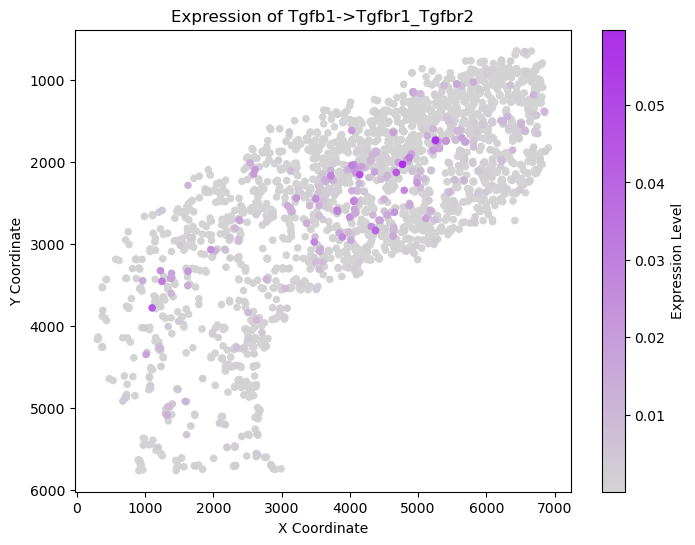

In [ ]:
gene = 'Tgfb1->Tgfbr1_Tgfbr2'
gene_expression = LRI_score[gene]

coord_cell_type = cell_loc.copy()
coord_cell_type['cell_type'] = cell_clus['celltype']
merged_data = coord_cell_type.join(gene_expression.rename('expression'))
merged_data = merged_data.sort_values(by='expression')

plt.figure(figsize=(8, 6))
colors = ["#D3D3D3", "#AD2DE9"]
cmap_custom = LinearSegmentedColormap.from_list("lightgray_to_blue", colors)
sc = plt.scatter(merged_data['y'], merged_data['x'], c=merged_data['expression'], cmap=cmap_custom, s=20)
plt.gca().invert_yaxis()

plt.colorbar(sc, label='Expression Level')
plt.title(f'Expression of {gene}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

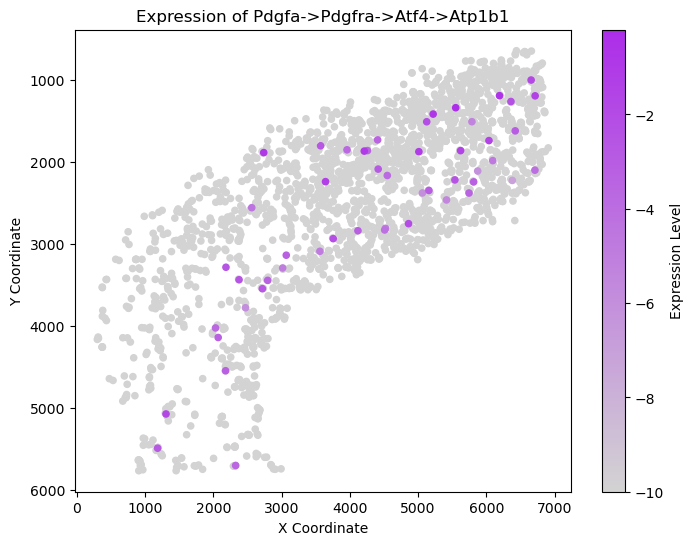

In [29]:
gene = 'Pdgfa->Pdgfra->Atf4->Atp1b1'
data = ccc[gene]
gene_expression = np.log10(data*10**9+ 1e-10)

coord_cell_type = cell_loc.copy()
coord_cell_type['cell_type'] = cell_clus['celltype']
merged_data = coord_cell_type.join(gene_expression.rename('expression'))
merged_data = merged_data.sort_values(by='expression')

plt.figure(figsize=(8, 6))
colors = ["#D3D3D3", "#AD2DE9"]
cmap_custom = LinearSegmentedColormap.from_list("lightgray_to_blue", colors)
sc = plt.scatter(merged_data['y'], merged_data['x'], c=merged_data['expression'], cmap=cmap_custom, s=20)
plt.gca().invert_yaxis()

plt.colorbar(sc, label='Expression Level')
plt.title(f'Expression of {gene}')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

## Plot the communication direction only for the significant spots for focused pair/path

In [ ]:
from matplotlib.patches import FancyArrowPatch, ArrowStyle

In [ ]:
Nei_adj = pd.read_csv(base_path + 'CCC/Nei_adj.csv', sep='\t', index_col=None, header=None)
lr_with_pathway = pd.read_csv(base_path + 'inputs/LRpairDB_merge_with_pathway.csv', sep=',')
lr_with_pathway['LR_Symbol'] = lr_with_pathway['Ligand_Symbol'] + '->' + lr_with_pathway['Receptor_Symbol']
adj = MC.Visualization.get_sender_adj(Nei_adj, cell_clus)
Sig_LR = pd.read_csv(base_path + 'CCC/Sig_Res/Significant_LRs.csv')  
pathway_mapping = lr_with_pathway.set_index('LR_Symbol')['Pathway_Name'].to_dict()
Sig_LR['Pathway_Name'] = Sig_LR['LR_Symbol'].map(pathway_mapping)
pathway_name = 'EGF'
res_all_df = MC.Visualization.get_Sig_all_vectors(pathway_name, Sig_LR, cell_clus, cell_loc, adj)
res_weighted_df = MC.Visualization.get_Sig_weighted_one_vector(res_all_df)
res_weighted_df.head()

,Sample_Name,Inter_Score,Z_Score,Sender,Sender_x,Sender_y,Receiver_x,Receiver_y
0,AAACGAACAATTCGTG-1,0.025040,6.190245,36,651.171169,6561.298418,660.651516,6537.772755
1,AAACGAACAATTCGTG-1,0.025723,6.190245,61,655.162713,6563.534798,659.708540,6538.010397
2,AAACGAACAATTCGTG-1,0.024998,6.190245,177,645.432770,6658.766355,662.765556,6563.014454
3,AAACGAACAATTCGTG-1,0.024023,6.190245,595,664.526097,6563.045067,657.631550,6536.329553
4,AAACGAACAATTCGTG-1,0.025187,6.190245,1034,690.840561,6423.954593,674.627808,6514.758414


In [5]:
color_map = {
    'Astro': '#1f77b4',       
    'Ex-L2/3 IT': '#ff7f0e',  
    'Ex-L4/5 IT': '#2ca02c',  
    'Ex-L5 NP': '#d62728',    
    'Ex-L5 PT': '#9467bd',    
    'Ex-L6 IT': '#8c564b',    
    'Ex-L6 CT': '#e377c2',    
    'Ex-L6b': '#7f7f7f',
    'Oligo': '#bcbd22'        
}
coord_df = cell_loc.copy()
coord_df['color'] = cell_clus['cell_type'].map(color_map)

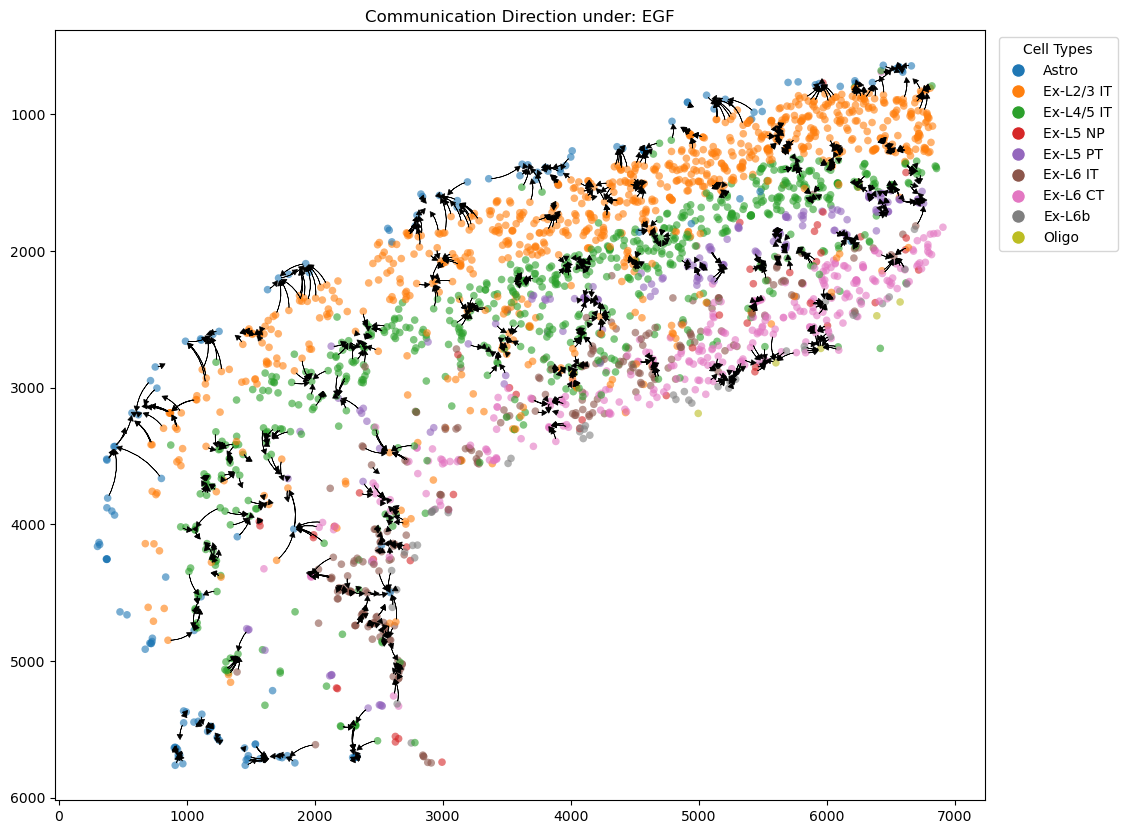

In [21]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(coord_df['y'], coord_df['x'],
                     c=coord_df['color'], alpha=0.6, s=30, linewidths=0) 
plt.gca().invert_yaxis() 
for index, row in res_weighted_df.iterrows():
    strength = row['Inter_Score']
    lw = max(0.5, strength * 1e1)
    arrowstyle = ArrowStyle("Simple", head_length=1.8, head_width=2, tail_width=0.01)
    arrow = FancyArrowPatch((row['Sender_y'],row['Sender_x']), 
                            (row['Receiver_y'], row['Receiver_x']),
                            connectionstyle="arc3,rad=0.2", 
                            arrowstyle=arrowstyle, color='black', lw=lw,
                            mutation_scale=2)
    plt.gca().add_patch(arrow)
    
handles = [plt.Line2D([0], [0], marker='o', color='w', label=celltype, markerfacecolor=color, markersize=10)
           for celltype, color in color_map.items()]
plt.legend(handles=handles, title='Cell Types', bbox_to_anchor=(1.15, 1), loc= 'upper right')

plt.title('Communication Direction under: '+ pathway_name)
plt.show()

## Plot the Relay network only for the significant spots for focused pair/path

In [ ]:
db_with_pathway = pd.read_csv(base_path + 'inputs/Ligand_Receptor_TF_TG_pairs_with_pathway.csv', sep=',')
Nei_adj = pd.read_csv(base_path + 'CCC/Nei_adj.csv', sep='\t', index_col=None, header=None)
lr_with_pathway = pd.read_csv(base_path + 'inputs/LRpairDB_merge_with_pathway.csv', sep=',')
lr_with_pathway['LR_Symbol'] = lr_with_pathway['Ligand_Symbol'] + '->' + lr_with_pathway['Receptor_Symbol']
adj = MC.Visualization.get_sender_adj(Nei_adj, cell_clus)
Sig_LR = pd.read_csv(base_path + 'CCC/Sig_Res/Significant_LRs.csv') 

In [ ]:
x_relay_y = MC.Visualization.find_signal_paths_with_relay(Nei_adj)
x_relay_y['x_name'] = cell_clus.index[x_relay_y['x']]
x_relay_y['relay_name'] = cell_clus.index[x_relay_y['relay']]
x_relay_y['y_name'] = cell_clus.index[x_relay_y['y']]
Sig_path = Sig_LR.copy()
Sig_path.rename(columns={'LR_Symbol': 'Path_Symbol', 'Inter_Score': 'Comm_Score'}, inplace=True)
pathway_name = 'NCAM'
sublr = lr_with_pathway[lr_with_pathway['Pathway_Name'] == pathway_name]
lr_lst = sublr['Ligand_Symbol'] + '->' + sublr['Receptor_Symbol']
sub_sig_path = Sig_path[Sig_path['Path_Symbol'].isin(lr_lst)]
sig_x_relay_y = MC.Visualization.create_sig_x_relay_y(x_relay_y, sub_sig_path)

Processing paths: 100%|██████████| 228362/228362 [00:09<00:00, 25301.57it/s]


In [9]:
combination_counts = sig_x_relay_y.groupby(['XR_Path_Symbol', 'RY_Path_Symbol']).size().reset_index(name='Count') 
combination_counts = combination_counts.sort_values('Count', ascending=False) 
combination_counts.head()

,XR_Path_Symbol,RY_Path_Symbol,Count
3,Ncam1->Ncam2,Ncam1->Ncam2,58792
2,Ncam1->Ncam2,Ncam1->Ncam1,2649
1,Ncam1->Ncam1,Ncam1->Ncam2,2399
0,Ncam1->Ncam1,Ncam1->Ncam1,928


In [10]:
pair1 = 'Ncam1->Ncam2' 
pair2 = 'Ncam1->Ncam1' 
cur_df = sig_x_relay_y[(sig_x_relay_y['XR_Path_Symbol'] == pair1) & (sig_x_relay_y['RY_Path_Symbol'] == pair2)] 
cur_df.head()

,X_Name,Relay_Name,Y_Name,XR_Path_Symbol,XR_Comm_Score,RY_Path_Symbol,RY_Comm_Score
74,AACAGTCAGGTGTCGA-1,CGCTATCTCGTTGTTT-1,GGAGAACTCGAGTGTT-1,Ncam1->Ncam2,0.207818,Ncam1->Ncam1,0.118709
79,AACAGTCAGGTGTCGA-1,CGCTATCTCGTTGTTT-1,GATGATCTCACGATTG-1,Ncam1->Ncam2,0.207818,Ncam1->Ncam1,0.135454
82,AACAGTCAGGTGTCGA-1,CGCTATCTCGTTGTTT-1,TCAAGGTTCCTCAAGA-1,Ncam1->Ncam2,0.207818,Ncam1->Ncam1,0.137411
86,GCAGATTGTCGGCTGT-1,CGCTATCTCGTTGTTT-1,GGAGAACTCGAGTGTT-1,Ncam1->Ncam2,0.207818,Ncam1->Ncam1,0.118709
89,GCAGATTGTCGGCTGT-1,CGCTATCTCGTTGTTT-1,GATGATCTCACGATTG-1,Ncam1->Ncam2,0.207818,Ncam1->Ncam1,0.135454


In [12]:
cur_xr = pd.DataFrame({
    'sender_x': cur_df['X_Name'].map(cell_loc['x']),
    'sender_y': cur_df['X_Name'].map(cell_loc['y']),
    'receiver_x': cur_df['Relay_Name'].map(cell_loc['x']),
    'receiver_y': cur_df['Relay_Name'].map(cell_loc['y']),
    'score': cur_df['XR_Comm_Score']
})
cur_ry = pd.DataFrame({
    'sender_x': cur_df['Relay_Name'].map(cell_loc['x']),
    'sender_y': cur_df['Relay_Name'].map(cell_loc['y']),
    'receiver_x': cur_df['Y_Name'].map(cell_loc['x']),
    'receiver_y': cur_df['Y_Name'].map(cell_loc['y']),
    'score': cur_df['RY_Comm_Score']
})

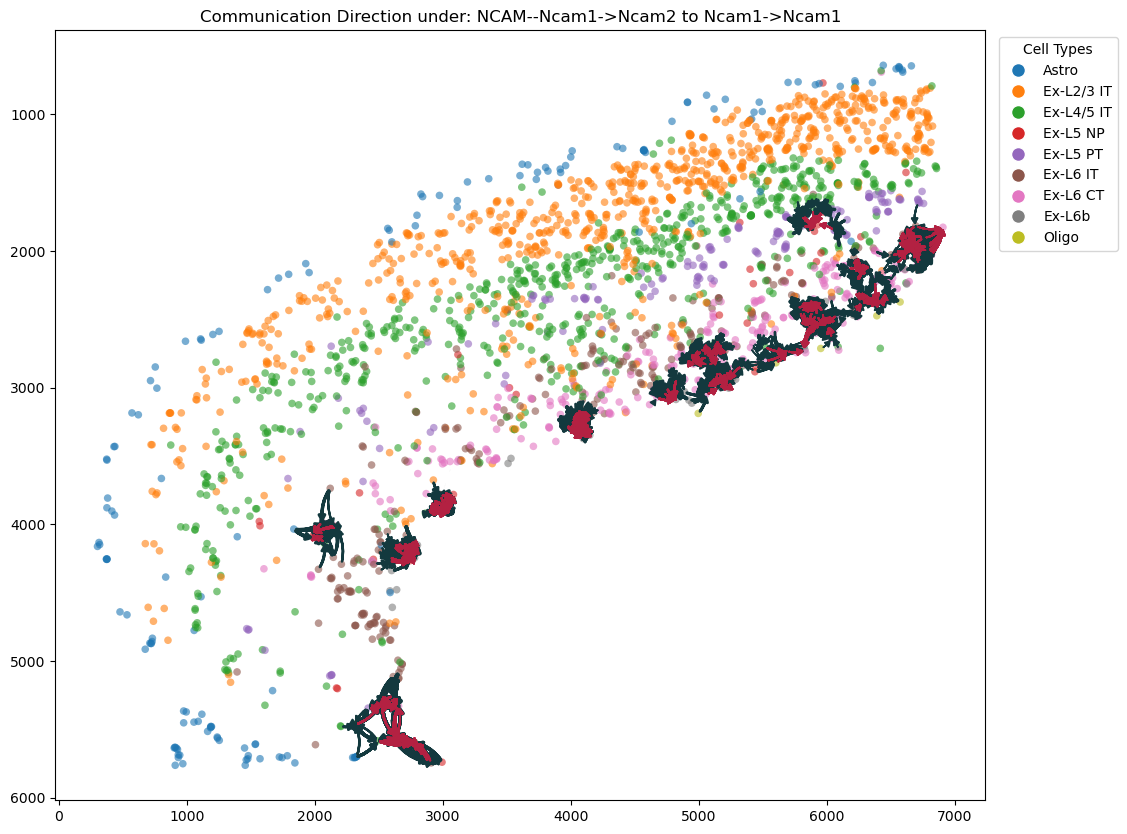

In [14]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(coord_df['y'], coord_df['x'],
                     c=coord_df['color'], alpha=0.6, s=30, linewidths=0) 
plt.gca().invert_yaxis() 
for index, row in cur_xr.iterrows():
    strength = row['score']
    lw = max(0.5, strength * 1e1)
    arrowstyle = ArrowStyle("Simple", head_length=1.8, head_width=2, tail_width=0.01)
    arrow = FancyArrowPatch((row['sender_y'],row['sender_x']), 
                            (row['receiver_y'], row['receiver_x']),
                            connectionstyle="arc3,rad=0.2", 
                            arrowstyle=arrowstyle, color='#13393E', lw=lw,
                            mutation_scale=2)
    plt.gca().add_patch(arrow)
    
for index, row in cur_ry.iterrows():
    strength = row['score']
    lw = max(0.5, strength * 1e1)
    arrowstyle = ArrowStyle("Simple", head_length=1.8, head_width=2, tail_width=0.01)
    arrow = FancyArrowPatch((row['sender_y'],row['sender_x']), 
                            (row['receiver_y'], row['receiver_x']),
                            connectionstyle="arc3,rad=0.2", 
                            arrowstyle=arrowstyle, color='#B32142', lw=lw,
                            mutation_scale=2)
    plt.gca().add_patch(arrow)
    
handles = [plt.Line2D([0], [0], marker='o', color='w', label=celltype, markerfacecolor=color, markersize=10)
           for celltype, color in color_map.items()]
plt.legend(handles=handles, title='Cell Types', bbox_to_anchor=(1.15, 1), loc= 'upper right')

plt.title('Communication Direction under: '+ pathway_name +'--' + pair1 + ' to ' + pair2)
plt.show()